## Dependencies

In [ ]:
%pip install rdkit
%pip install lazypredict
%pip install umap-learn
%pip install git+https://github.com/samoturk/mol2vec
%pip install optuna

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-hm0572_7
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-hm0572_7
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from itertools import product


from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import MACCSkeys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from mol2vec import features
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from lightgbm import LGBMRegressor
from gensim.models import Word2Vec

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Data preparation

Проверю данные датасета, их качество и количество:

In [ ]:
df = pd.read_csv('melting_points.csv')
df.head()

,smiles,value,source,name,units,params
0,CC1(C)c2ccccc2-c2ccc(N(c3ccc4c(c3)C3(c5ccccc5-...,255.80,ECHA,Melting point,°C,NaN
1,Cc1ccc(C=CCl)cc1,35.50,NaN,Melting point,°C,NaN
2,COc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,194.00,NaN,Melting point,°C,NaN
3,CC=Cc1ccc(OCC)cc1,60.33,NaN,Melting point,°C,NaN
4,CCCCCCCCCCc1cccc2ccccc12,15.00,NaN,Melting point,°C,NaN


In [ ]:
df.shape

(11699, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11699 entries, 0 to 11698
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  11699 non-null  object 
 1   value   11699 non-null  float64
 2   source  5690 non-null   object 
 3   name    11699 non-null  object 
 4   units   11699 non-null  object 
 5   params  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 548.5+ KB


In [ ]:
df.describe()

,value,params
count,11699.00,0.00
mean,31.03,NaN
std,91.19,NaN
min,-205.02,NaN
25%,-27.48,NaN
50%,25.50,NaN
75%,78.00,NaN
max,1300.00,NaN


Посмотрю, сколько дубликатов smiles

In [ ]:
repeated_smiles = df[df.smiles.duplicated()].smiles.unique()
len(repeated_smiles)

0

Визуализация выбросов по правилу 3-х сигм

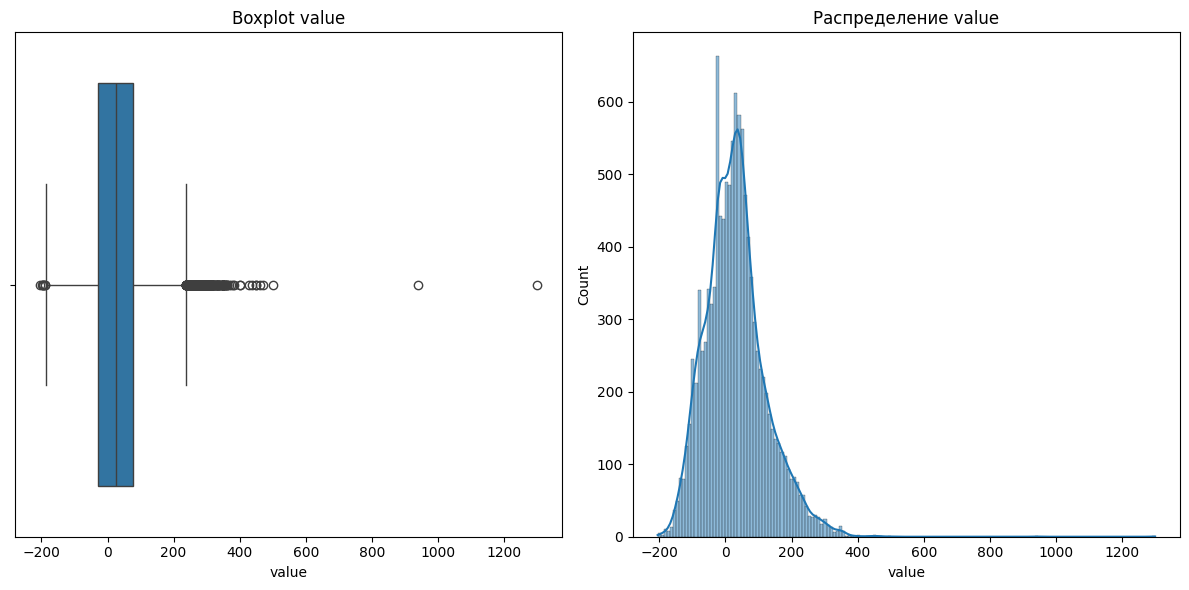

In [ ]:
def plot_outliers(df, target_col='value'):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[target_col])
    plt.title(f'Boxplot {target_col}')

    plt.subplot(1, 2, 2)
    sns.histplot(df[target_col], kde=True)
    plt.title(f'Распределение {target_col}')
    plt.tight_layout()
    plt.show()

plot_outliers(df, 'value')

Удалю выбросы

Найдено 86 выбросов в value


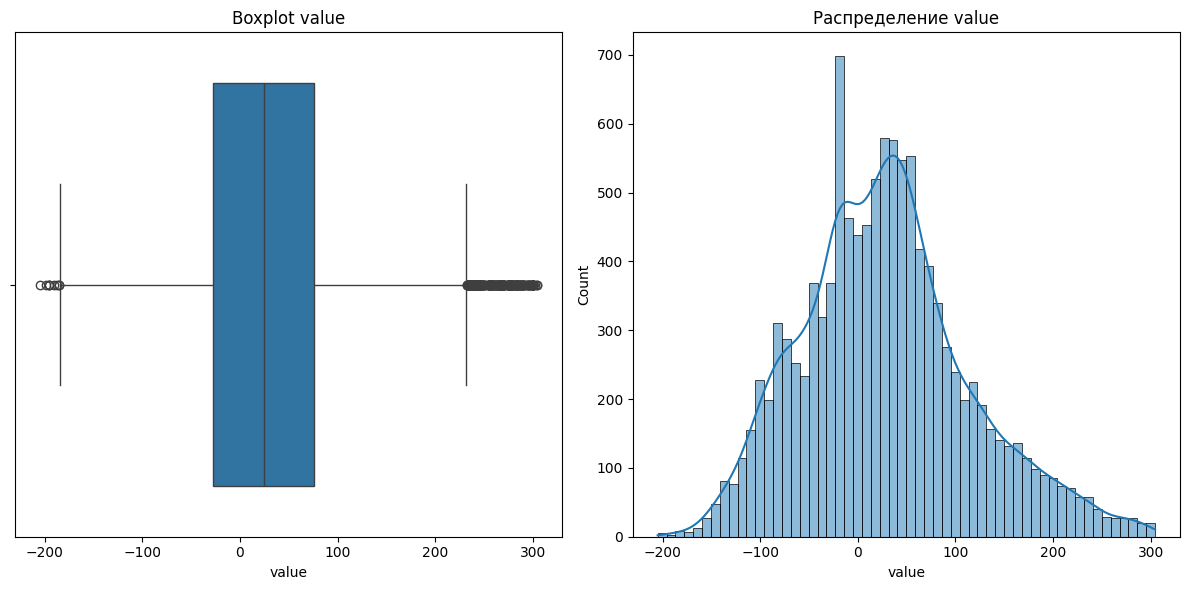

Выходные данные были обрезаны до нескольких последних строк (5000).
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use MorganGenerator
[08:16:03] DEPRECATION WARNING: please use Morg

Финальный размер данных:
X shape: (11613, 256)
y_bp shape: (11613,)


[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerator
[08:16:06] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
def remove_outliers(data, target_col, threshold=3):
    mean = data[target_col].mean()
    std = data[target_col].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    outliers = data[(data[target_col] < lower_bound) | (data[target_col] > upper_bound)]
    print(f"Найдено {len(outliers)} выбросов в {target_col}")
    return data[(data[target_col] >= lower_bound) & (data[target_col] <= upper_bound)]

df_clean = remove_outliers(df, 'value')
plot_outliers(df_clean, 'value')

def smiles_to_fp(smiles_list, radius=3, n_bits=256):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fps.append(np.array(fp))
        else:
            fps.append(np.zeros(n_bits))
    return np.vstack(fps)

X = smiles_to_fp(df_clean['smiles'])
y_bp = df_clean['value'].values

print("Финальный размер данных:")
print(f"X shape: {X.shape}")
print(f"y_bp shape: {y_bp.shape}")

In [ ]:
df_clean.shape

(11613, 6)

# Morgan fingerprints

Перевод smiles в fingerprints

In [ ]:
def get_fingerprint(smiles):
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(smiles)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=256)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [ ]:
df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)

Выходные данные были обрезаны до нескольких последних строк (5000).
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use MorganGenerator
[08:16:34] DEPRECATION WARNING: please use Morg

In [ ]:
X = np.stack(df_clean.fp.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df_clean['value']

Разделю данные на train и test

In [ ]:
# 1. Сначала на train и temp (test + validation) с соотношением 0.8 и 0.2 соответственно
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Далее temp на test и validation с соотношением 50% на 50%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Использую для подбора модели МО Lazy Predict

Добавление дескрипторов

In [ ]:
def get_fingerprint(smiles, radius=2, n_bits=256):
    fp_array = np.zeros((0,), dtype=np.int8)
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    ConvertToNumpyArray(fp, fp_array)
    return fp_array

def get_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(5)

    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAmideBonds(mol)
    ]
    return np.array(descriptors)

df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

Выходные данные были обрезаны до нескольких последних строк (5000).
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use MorganGenerator
[08:31:45] DEPRECATION WARNING: please use Morg

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.48,0.60,55.33,1.06
HistGradientBoostingRegressor,0.47,0.59,55.72,3.79
RandomForestRegressor,0.45,0.58,56.72,31.10
XGBRegressor,0.45,0.57,56.75,1.47
ExtraTreesRegressor,0.44,0.57,57.31,46.58
GradientBoostingRegressor,0.41,0.54,58.73,9.68
BaggingRegressor,0.40,0.53,59.43,3.43
LassoLarsCV,0.33,0.48,62.48,2.13
LassoCV,0.33,0.48,62.49,1.68


Вывод: LGBMRegressor - лучшая модель, выбираю ее в качестве модели МО.

Подбор гиперпараметров на лучшей модели

In [ ]:
def objective(trial):
    params = {
    'boosting_type': 'gbdt',
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
    'num_leaves': trial.suggest_int('num_leaves', 31, 127),
    'max_depth': -1,
    'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
}

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-08-19 09:01:03,927] A new study created in memory with name: no-name-4ba21413-3f03-41cc-909c-51bf0aed45cd


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:04,963] Trial 0 finished with value: 4011.1074926128376 and parameters: {'learning_rate': 0.010719293118972772, 'num_leaves': 97, 'min_child_samples': 56, 'reg_alpha': 7.510663231938011, 'reg_lambda': 0.12645484693124986}. Best is trial 0 with value: 4011.1074926128376.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:05,927] Trial 1 finished with value: 3086.372177593222 and parameters: {'learning_rate': 0.19842601025335796, 'num_leaves': 102, 'min_child_samples': 12, 'reg_alpha': 7.342522623051044, 'reg_lambda': 8.617424266161436}. Best is trial 1 with value: 3086.372177593222.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:06,538] Trial 2 finished with value: 3036.6232341154305 and parameters: {'learning_rate': 0.1624972194133189, 'num_leaves': 79, 'min_child_samples': 78, 'reg_alpha': 3.264194303895047, 'reg_lambda': 2.709744584717002}. Best is trial 2 with value: 3036.6232341154305.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:07,102] Trial 3 finished with value: 3079.2983570502315 and parameters: {'learning_rate': 0.17543684122546704, 'num_leaves': 74, 'min_child_samples': 26, 'reg_alpha': 6.3959135831158465, 'reg_lambda': 2.4766992788013087}. Best is trial 2 with value: 3036.6232341154305.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:07,750] Trial 4 finished with value: 3041.781262813087 and parameters: {'learning_rate': 0.16287342357849668, 'num_leaves': 124, 'min_child_samples': 76, 'reg_alpha': 5.888027500051315, 'reg_lambda': 0.0860623256346893}. Best is trial 2 with value: 3036.6232341154305.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-19 09:01:08,287] Trial 5 finished with value: 2964.4943844412555 and parameters: {'learning_rate': 0.15009646955459094, 'num_leaves': 58, 'min_child_samples': 99, 'reg_alpha': 2.790507374763634, 'reg_lambda': 8.461637362726982}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:08,870] Trial 6 finished with value: 3086.0463232000484 and parameters: {'learning_rate': 0.06931653509312857, 'num_leaves': 64, 'min_child_samples': 66, 'reg_alpha': 6.628065000779891, 'reg_lambda': 2.6331631624239438}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:09,321] Trial 7 finished with value: 3104.9174257527666 and parameters: {'learning_rate': 0.07142915705121321, 'num_leaves': 34, 'min_child_samples': 52, 'reg_alpha': 4.07712189119891, 'reg_lambda': 5.544166121154717}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:09,929] Trial 8 finished with value: 3017.008088201739 and parameters: {'learning_rate': 0.08030253301095298, 'num_leaves': 76, 'min_child_samples': 72, 'reg_alpha': 7.26735445940856, 'reg_lambda': 3.9150222802657586}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:10,582] Trial 9 finished with value: 3033.253794608918 and parameters: {'learning_rate': 0.14383630429069377, 'num_leaves': 90, 'min_child_samples': 15, 'reg_alpha': 9.230302317450864, 'reg_lambda': 5.972239852374365}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:11,087] Trial 10 finished with value: 3054.356139908226 and parameters: {'learning_rate': 0.11735493832516207, 'num_leaves': 47, 'min_child_samples': 96, 'reg_alpha': 0.5521013737761518, 'reg_lambda': 9.722824338798915}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:11,610] Trial 11 finished with value: 2993.882527653712 and parameters: {'learning_rate': 0.10080314035007734, 'num_leaves': 56, 'min_child_samples': 99, 'reg_alpha': 2.136807105059469, 'reg_lambda': 7.253170846720755}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:12,132] Trial 12 finished with value: 3031.2439234825374 and parameters: {'learning_rate': 0.11221399087756063, 'num_leaves': 52, 'min_child_samples': 100, 'reg_alpha': 1.8643602230333594, 'reg_lambda': 7.592088111718796}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:12,890] Trial 13 finished with value: 3064.3917689932273 and parameters: {'learning_rate': 0.128243373999128, 'num_leaves': 56, 'min_child_samples': 85, 'reg_alpha': 2.439346758547502, 'reg_lambda': 7.181078089820915}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:13,579] Trial 14 finished with value: 3080.8088721824074 and parameters: {'learning_rate': 0.09361161791018895, 'num_leaves': 33, 'min_child_samples': 88, 'reg_alpha': 0.26418901909414183, 'reg_lambda': 9.777281793638373}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:14,523] Trial 15 finished with value: 3150.625156977573 and parameters: {'learning_rate': 0.04636290145536983, 'num_leaves': 64, 'min_child_samples': 41, 'reg_alpha': 4.48724442390953, 'reg_lambda': 7.153368398967688}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:15,285] Trial 16 finished with value: 3043.816166436368 and parameters: {'learning_rate': 0.13721949022419955, 'num_leaves': 45, 'min_child_samples': 89, 'reg_alpha': 1.6401322445592441, 'reg_lambda': 8.465544368557259}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:16,134] Trial 17 finished with value: 3250.813870024417 and parameters: {'learning_rate': 0.039434690475731615, 'num_leaves': 62, 'min_child_samples': 100, 'reg_alpha': 3.23249735132781, 'reg_lambda': 6.320805913680742}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:16,697] Trial 18 finished with value: 3037.6245026239703 and parameters: {'learning_rate': 0.10173092052728866, 'num_leaves': 41, 'min_child_samples': 61, 'reg_alpha': 1.2439697081479686, 'reg_lambda': 4.667682668811054}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:17,507] Trial 19 finished with value: 3122.964118723549 and parameters: {'learning_rate': 0.1915115598414487, 'num_leaves': 127, 'min_child_samples': 39, 'reg_alpha': 2.86564899975428, 'reg_lambda': 8.528963982031648}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:18,157] Trial 20 finished with value: 3012.449844176983 and parameters: {'learning_rate': 0.1515900346650912, 'num_leaves': 85, 'min_child_samples': 82, 'reg_alpha': 5.34908405362867, 'reg_lambda': 7.924543217956845}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:18,738] Trial 21 finished with value: 3057.584736040574 and parameters: {'learning_rate': 0.14778026213983833, 'num_leaves': 91, 'min_child_samples': 90, 'reg_alpha': 4.956018511693508, 'reg_lambda': 7.830618981922148}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:19,374] Trial 22 finished with value: 3057.8662250740304 and parameters: {'learning_rate': 0.16192575368156115, 'num_leaves': 110, 'min_child_samples': 81, 'reg_alpha': 3.7027386232929835, 'reg_lambda': 9.205086307598258}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-08-19 09:01:19,966] Trial 23 finished with value: 3053.4342319254943 and parameters: {'learning_rate': 0.12476319085130919, 'num_leaves': 84, 'min_child_samples': 92, 'reg_alpha': 5.049801303378294, 'reg_lambda': 6.554520345503904}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:20,553] Trial 24 finished with value: 3066.7386936760868 and parameters: {'learning_rate': 0.18268835205498757, 'num_leaves': 72, 'min_child_samples': 95, 'reg_alpha': 2.1602276328725876, 'reg_lambda': 8.194807180332472}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:21,116] Trial 25 finished with value: 3091.493972870532 and parameters: {'learning_rate': 0.08572591969768727, 'num_leaves': 58, 'min_child_samples': 70, 'reg_alpha': 5.711148787488049, 'reg_lambda': 6.866519184710546}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:21,706] Trial 26 finished with value: 2988.0106359589236 and parameters: {'learning_rate': 0.15296601552972794, 'num_leaves': 65, 'min_child_samples': 82, 'reg_alpha': 1.073522185377717, 'reg_lambda': 5.074288470527991}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:22,285] Trial 27 finished with value: 3016.950311170496 and parameters: {'learning_rate': 0.10397421454299853, 'num_leaves': 67, 'min_child_samples': 96, 'reg_alpha': 1.0868886940173124, 'reg_lambda': 4.900289811039428}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:22,797] Trial 28 finished with value: 3045.179525419581 and parameters: {'learning_rate': 0.1315649326066958, 'num_leaves': 49, 'min_child_samples': 85, 'reg_alpha': 0.058085212449697554, 'reg_lambda': 4.422503943315419}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:23,295] Trial 29 finished with value: 4228.949128050432 and parameters: {'learning_rate': 0.010672314231549546, 'num_leaves': 39, 'min_child_samples': 55, 'reg_alpha': 1.1652381816842876, 'reg_lambda': 3.51440801180326}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:23,833] Trial 30 finished with value: 3031.65944484759 and parameters: {'learning_rate': 0.1736761920135238, 'num_leaves': 57, 'min_child_samples': 100, 'reg_alpha': 2.1130458700717667, 'reg_lambda': 1.3765258525970165}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:24,446] Trial 31 finished with value: 3031.9288406905716 and parameters: {'learning_rate': 0.15106246111710073, 'num_leaves': 83, 'min_child_samples': 81, 'reg_alpha': 2.8135484490099083, 'reg_lambda': 5.373648810027811}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:25,023] Trial 32 finished with value: 3021.4762031889377 and parameters: {'learning_rate': 0.15180856310716362, 'num_leaves': 69, 'min_child_samples': 74, 'reg_alpha': 3.936769458603413, 'reg_lambda': 9.117745422844704}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:25,699] Trial 33 finished with value: 3033.5487477894194 and parameters: {'learning_rate': 0.11317350094641829, 'num_leaves': 102, 'min_child_samples': 64, 'reg_alpha': 8.617213986366378, 'reg_lambda': 7.763102421037881}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:26,306] Trial 34 finished with value: 3047.817269942871 and parameters: {'learning_rate': 0.1635625402386909, 'num_leaves': 82, 'min_child_samples': 83, 'reg_alpha': 0.6933267199273703, 'reg_lambda': 5.985605065109019}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:27,146] Trial 35 finished with value: 3069.7727001516596 and parameters: {'learning_rate': 0.19787286479550806, 'num_leaves': 54, 'min_child_samples': 78, 'reg_alpha': 3.3884577330615073, 'reg_lambda': 9.031627384656112}. Best is trial 5 with value: 2964.4943844412555.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:28,062] Trial 36 finished with value: 2936.2609044705196 and parameters: {'learning_rate': 0.17657880320047548, 'num_leaves': 89, 'min_child_samples': 93, 'reg_alpha': 5.380697504510989, 'reg_lambda': 1.8172956771599376}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:28,988] Trial 37 finished with value: 3051.9067020300586 and parameters: {'learning_rate': 0.17374212009930115, 'num_leaves': 101, 'min_child_samples': 93, 'reg_alpha': 4.428277017186817, 'reg_lambda': 0.9859895290782443}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:29,924] Trial 38 finished with value: 3103.914909846929 and parameters: {'learning_rate': 0.054958835720247026, 'num_leaves': 108, 'min_child_samples': 89, 'reg_alpha': 6.5052101310698465, 'reg_lambda': 3.4551857590533004}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:30,707] Trial 39 finished with value: 3039.667200925092 and parameters: {'learning_rate': 0.18681697787825893, 'num_leaves': 75, 'min_child_samples': 96, 'reg_alpha': 2.5516279993024256, 'reg_lambda': 2.2382537088744705}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-19 09:01:31,361] Trial 40 finished with value: 3060.1360867468347 and parameters: {'learning_rate': 0.1608312892021938, 'num_leaves': 91, 'min_child_samples': 77, 'reg_alpha': 1.5528902772192885, 'reg_lambda': 1.702328882833795}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:31,980] Trial 41 finished with value: 3024.616720700708 and parameters: {'learning_rate': 0.13861826989490206, 'num_leaves': 96, 'min_child_samples': 85, 'reg_alpha': 5.549820970789101, 'reg_lambda': 4.079027449293508}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:32,560] Trial 42 finished with value: 3058.6012848580244 and parameters: {'learning_rate': 0.17881794080649027, 'num_leaves': 62, 'min_child_samples': 69, 'reg_alpha': 7.323698721895539, 'reg_lambda': 0.5339384621005416}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:33,146] Trial 43 finished with value: 3006.131906532797 and parameters: {'learning_rate': 0.16970114720900337, 'num_leaves': 69, 'min_child_samples': 93, 'reg_alpha': 6.08865414103733, 'reg_lambda': 7.322134697263153}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-19 09:01:33,715] Trial 44 finished with value: 3111.0083078702546 and parameters: {'learning_rate': 0.16664136591173964, 'num_leaves': 70, 'min_child_samples': 93, 'reg_alpha': 8.143484625612253, 'reg_lambda': 5.419651731256308}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-08-19 09:01:34,290] Trial 45 finished with value: 3048.3740867205593 and parameters: {'learning_rate': 0.19414095134585607, 'num_leaves': 76, 'min_child_samples': 100, 'reg_alpha': 6.814977725264892, 'reg_lambda': 7.402009460298219}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:34,829] Trial 46 finished with value: 2999.8390130467087 and parameters: {'learning_rate': 0.12330528120988085, 'num_leaves': 60, 'min_child_samples': 88, 'reg_alpha': 4.463335308725146, 'reg_lambda': 2.9667160663183982}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:35,396] Trial 47 finished with value: 3039.0851485495805 and parameters: {'learning_rate': 0.12349498914000843, 'num_leaves': 59, 'min_child_samples': 88, 'reg_alpha': 4.695402971359582, 'reg_lambda': 2.9459907489878527}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:35,903] Trial 48 finished with value: 3067.4148201004477 and parameters: {'learning_rate': 0.13581117046430496, 'num_leaves': 50, 'min_child_samples': 44, 'reg_alpha': 3.651532114544828, 'reg_lambda': 3.0106832460341004}. Best is trial 36 with value: 2936.2609044705196.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394


[I 2025-08-19 09:01:36,510] Trial 49 finished with value: 3059.10543287012 and parameters: {'learning_rate': 0.09391545967446879, 'num_leaves': 65, 'min_child_samples': 20, 'reg_alpha': 0.831937271346004, 'reg_lambda': 2.3333892185393554}. Best is trial 36 with value: 2936.2609044705196.


Best hyperparameters: {'learning_rate': 0.17657880320047548, 'num_leaves': 89, 'min_child_samples': 93, 'reg_alpha': 5.380697504510989, 'reg_lambda': 1.8172956771599376}
Best RMSE: 2936.2609044705196


Подбор параметров для Morgan fingerprints

In [ ]:
radius = [2, 3]
nbits = [128, 256, 512]

In [ ]:
hgbm = LGBMRegressor(random_state=0)

In [ ]:
best_score = 0
best_params = None

for r in radius:
  for b in nbits:

    def get_fingerprint(smiles):
      fp_array = np.zeros((0,), dtype=np.int8)
      mol = Chem.MolFromSmiles(smiles)
      fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=b)
      ConvertToNumpyArray(fp, fp_array)
      return fp_array

    hgbm.fit(X_train, y_train)
    score = hgbm.score(X_val, y_val)

    print(f'r={r}, nBits={b}, score={score}')

    if score > best_score:
      best_score = score
      best_params = (r, b)

print("Максимальный score:", best_score)
print("Параметры с максимальным score (r, nBits):", best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
r=2, nBits=128, score=0.592398000099247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 264
[LightGBM] [Info] Start training from score 28.051394
r=2, nBits=256, score=0.592398000099247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021692 seconds.
Yo

Обучение модели:

In [ ]:
best_params = study.best_params

r = 2
nBits = 128

def get_fingerprint(smiles):
    fp_array = np.zeros((0,), dtype=np.int8)
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    ConvertToNumpyArray(fp, fp_array)
    return fp_array

df_clean['fp'] = df_clean['smiles'].apply(get_fingerprint)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



model = LGBMRegressor(**best_params, random_state=42)
model.fit(X, y)

y_train_pred = model.predict(X)
train_r2 = r2_score(y, y_train_pred)
train_mse = mean_squared_error(y, y_train_pred)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train R^2:", train_r2)
print("Train MSE:", train_mse)
print("Test R^2:", test_r2)
print("Test MSE:", test_mse)

Выходные данные были обрезаны до нескольких последних строк (5000).
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use MorganGenerator
[09:05:58] DEPRECATION WARNING: please use Morg

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1111
[LightGBM] [Info] Number of data points in the train set: 11613, number of used features: 136
[LightGBM] [Info] Start training from score 28.574513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Train R^2: 0.8283183669541152
Train MSE: 1277.1915378641015
Test R^2: 0.8293308459961864
Test MSE: 1243.2967951758421


Сохранение полученной модели

In [ ]:
import pickle
model_filename = "/content/drive/MyDrive/Syntelly/trained_model_melting_points.pkl"

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

Кросс-валидация:

In [ ]:
model = LGBMRegressor()

cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_results = np.sqrt(-cv_results)
print(f'Mean RMSE: {np.mean(cv_results)}, Std RMSE: {np.std(cv_results)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 7432, number of used features: 136
[LightGBM] [Info] Start training from score 27.714155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 7432, number of used features: 136
[LightGBM] [Info] Start training from score 28.228215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

Вывод: с данными фингепринтами и этой моделью МО LGBMRegressor, метрики наиболее хорошие. Значит, эта модель наиболее качеcтвенная.

# Mol2Vec
Mol2vec - an unsupervised machine learning approach to learn vector representations of molecular substructures.

In [ ]:
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [ ]:
mols = [Chem.MolFromSmiles(smi) for smi in df_clean['smiles']]

[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:34] WARNING: not removing hydrogen atom without neighbors
[10:25:35] WARNING: not removing hydrogen atom without neighbors


In [ ]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [ ]:
def sentences2vec_word2vec(sentences, model, unseen='UNK'):
    vectors = []
    vector_size = model.vector_size

    for sentence in sentences:
        sentence_vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
            else:
                if unseen is not None and unseen in model.wv.key_to_index:
                    sentence_vec.append(model.wv[unseen])
                else:
                    sentence_vec.append(np.zeros(vector_size))

        if sentence_vec:
            vectors.append(np.mean(sentence_vec, axis=0))
        else:
            vectors.append(np.zeros(vector_size))
    return vectors

df_clean['sentence'] = [mol2alt_sentence(m, 1) for m in mols]
mol2vec_vectors = sentences2vec_word2vec(df_clean['sentence'], model, unseen='UNK')
df_clean['mol2vec'] = mol2vec_vectors

df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_mol2vec = np.stack(df_clean['mol2vec'].values)
X_desc = np.stack(df_clean['descriptors'].values)
X = np.hstack([X_mol2vec, X_desc])

y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Выходные данные были обрезаны до нескольких последних строк (5000).
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use MorganGenerator
[11:31:15] DEPRECATION WARNING: please use Morg

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26354
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 108
[LightGBM] [Info] Start training from score 28.051394


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.54,0.59,53.82,2.26
LGBMRegressor,0.54,0.58,54.06,2.20
MLPRegressor,0.53,0.58,54.42,18.38
RandomForestRegressor,0.53,0.58,54.43,143.89
ExtraTreesRegressor,0.52,0.57,55.04,30.80
GradientBoostingRegressor,0.51,0.55,56.01,54.66
XGBRegressor,0.50,0.55,56.22,6.03
BaggingRegressor,0.48,0.53,57.37,14.23
KNeighborsRegressor,0.43,0.48,60.32,0.30


Вывод: HistGradientBoostingRegressor - лучшая модель

Подбор гиперпараметров модели:

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 10.0),
        'max_bins': trial.suggest_int('max_bins', 64, 255),
        'early_stopping': True,
        'random_state': 42
    }

    model = HistGradientBoostingRegressor(**params)

    scores = cross_val_score(model, X_train_vec, y_train_vec, cv=5, scoring='r2')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучшие гиперпараметры:", study.best_params)
print("Лучший R2:", study.best_value)

[I 2025-08-19 11:47:21,717] A new study created in memory with name: no-name-55198691-75ed-4859-9861-e2e77db0c77a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-19 11:47:25,993] Trial 0 finished with value: 0.5384695270662997 and parameters: {'learning_rate': 0.17028740045672433, 'max_iter': 319, 'max_depth': 8, 'min_samples_leaf': 71, 'l2_regularization': 7.377626409442575, 'max_bins': 180}. Best is trial 0 with value: 0.5384695270662997.
[I 2025-08-19 11:47:33,977] Trial 1 finished with value: 0.5477440093339897 and parameters: {'learning_rate': 0.10935474843707353, 'max_iter': 332, 'max_depth': 6, 'min_samples_leaf': 36, 'l2_regularization': 2.282575600566049, 'max_bins': 181}. Best is trial 1 with value: 0.5477440093339897.
[I 2025-08-19 11:47:40,537] Trial 2 finished with value: 0.5505412176742757 and parameters: {'learning_rate': 0.10187199207935091, 'max_iter': 377, 'max_depth': 8, 'min_samples_leaf': 84, 'l2_regularization': 2.6966111949537055, 'max_bins': 198}. Best is trial 2 with value: 0.5505412176742757.
[I 2025-08-19 11:47:45,257] Trial 3 finished with value: 0.5355048599541423 and parameters: {'learning_rate': 0.12870

Обучение модели:

In [ ]:
best_params = {
    'learning_rate': 0.0636403424681261,
    'max_iter': 280,
    'max_depth': 10,
    'min_samples_leaf': 56,
    'l2_regularization': 4.04242336204082,
    'max_bins': 148
}

best_model = HistGradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=4.04242336204082,
                              learning_rate=0.0636403424681261, max_bins=148,
                              max_depth=10, max_iter=280, min_samples_leaf=56)

In [ ]:
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train R^2:", train_r2)
print("Train MSE:", train_mse)
print("Test R^2:", test_r2)
print("Test MSE:", test_mse)

Train R^2: 0.8408389894241086
Train MSE: 1189.976677626295
Test R^2: 0.5994126547305325
Test MSE: 2802.5017299369233


# MACCS keys fingerprints

In [ ]:
def get_maccs_keys(smiles):
    """Converts SMILES into MACCS keys fingerprint."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = MACCSkeys.GenMACCSKeys(mol)
        return list(fp)
    else:
        return [0] * 167  # MACCS keys имеют фиксированную длину 167 бит


In [ ]:
df_clean['maccs'] = df_clean['smiles'].apply(get_maccs_keys)

X = np.stack(df_clean.maccs.apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
y = df_clean['value']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

[12:16:13] WARNING: not removing hydrogen atom without neighbors
[12:16:13] WARNING: not removing hydrogen atom without neighbors
[12:16:13] WARNING: not removing hydrogen atom without neighbors
[12:16:13] WARNING: not removing hydrogen atom without neighbors
[12:16:17] WARNING: not removing hydrogen atom without neighbors
[12:16:17] WARNING: not removing hydrogen atom without neighbors
[12:16:20] WARNING: not removing hydrogen atom without neighbors


С дескрипторами

In [ ]:
def get_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(5)

    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.RingCount(mol),
        Descriptors.NumRotatableBonds(mol),
        rdMolDescriptors.CalcNumAmideBonds(mol)
    ]
    return np.array(descriptors)

df_clean['fp'] = df_clean['smiles'].apply(get_maccs_keys)
df_clean['descriptors'] = df_clean['smiles'].apply(get_2d_descriptors)

X_fp = np.stack(df_clean['fp'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X_desc = np.stack(df_clean['descriptors'].apply(lambda x: np.array(x)).to_numpy()).astype(np.float64)
X = np.hstack([X_fp, X_desc])
y = df_clean['value'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)
models

[12:20:08] WARNING: not removing hydrogen atom without neighbors
[12:20:08] WARNING: not removing hydrogen atom without neighbors
[12:20:09] WARNING: not removing hydrogen atom without neighbors
[12:20:10] WARNING: not removing hydrogen atom without neighbors
[12:20:15] WARNING: not removing hydrogen atom without neighbors
[12:20:15] WARNING: not removing hydrogen atom without neighbors
[12:20:18] WARNING: not removing hydrogen atom without neighbors
[12:20:24] WARNING: not removing hydrogen atom without neighbors
[12:20:24] WARNING: not removing hydrogen atom without neighbors
[12:20:24] WARNING: not removing hydrogen atom without neighbors
[12:20:24] WARNING: not removing hydrogen atom without neighbors
[12:20:26] WARNING: not removing hydrogen atom without neighbors
[12:20:26] WARNING: not removing hydrogen atom without neighbors
[12:20:28] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 9290, number of used features: 163
[LightGBM] [Info] Start training from score 28.051394


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.53,0.60,55.03,0.57
HistGradientBoostingRegressor,0.53,0.60,55.17,2.96
RandomForestRegressor,0.52,0.59,55.43,17.94
XGBRegressor,0.51,0.58,56.24,0.65
MLPRegressor,0.49,0.57,57.22,26.86
BaggingRegressor,0.49,0.56,57.42,2.36
GradientBoostingRegressor,0.48,0.56,57.70,5.91
ExtraTreesRegressor,0.43,0.52,60.43,20.14
RidgeCV,0.43,0.52,60.48,0.38


Вывод: LGBMRegressor - лучшая модель для данных фингепринтов.

Гиперпараметры с дескрипторами:

In [ ]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)

    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"{key:>20}: {value}")

[I 2025-08-19 12:35:39,795] A new study created in memory with name: no-name-dd3999ce-37f7-475f-93f0-fe8e07b44282


  0%|          | 0/50 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Обучение модели с дексрипторами

In [ ]:
best_params = study.best_params

model = LGBMRegressor(**best_params)
model.fit(X, y)

y_train_pred = model.predict(X)
train_r2 = r2_score(y, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_pred = model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Результаты LGBMRegressor:")
print(f"Train R²: {train_r2:.4f}")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Разница Train-Test R²: {train_r2 - test_r2:.4f}")

Результаты LGBMRegressor:
Train R²: 0.7438
Train RMSE: 43.66
Test R²: 0.7478
Test RMSE: 42.86
Разница Train-Test R²: -0.0040
